* Boston 房价数据集
* 训练数据需要进行标准化
* 回归问题使用的损失函数(loss)与分类问题不同

### 导入安装包

In [1]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

### 导入数据集

In [2]:
import sklearn.datasets
data   = sklearn.datasets.load_boston()
Input  = np.array(data["data"])
Output = np.array(data["target"]).reshape(-1,1)
type(data['data'])

numpy.ndarray

#### 数据的标准化分析

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split    # 用于区分 训练数据和测试数据 

std_scalar_x = StandardScaler()                  #实例化类
x_rescale    = std_scalar_x.fit_transform(Input) 
std_scalar_y = StandardScaler()                  #实例化类
y_rescale    = std_scalar_y.fit_transform(Output)
train_input,test_input,train_output,test_output = train_test_split(x_rescale,y_rescale,train_size=0.7,random_state=0)


##直到训练模型的时候,再将数据转换成Tensor的形式
x = torch.from_numpy(train_input).float()       # 将numpy转成Tensor
y = torch.from_numpy(train_output).float()

D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


* Question: sklearn中存在StandardScalar进行标准化的包,在pyTorch中存在类似的包吗?
* Answer: PyTorch中可以用torchvision.transforms做数据预处理，但是它一般默认是做图像数据的预处理的，也就是数据是3D的（通道\*长度\*宽度），所以对于常规的面板数据（行是样本，列是特征），我们还是用最常见的sklearn.preprocessing来做预处理。


* Question: pyTorch存在自动将训练集分成"训练数据"和"校正数据"的函数么? 还是需要借助sklearn中的train_test_split
* Answer: 是的，我们可以利用sklearn把数据都准备好了之后再进入PyTorch的计算，也就是数据标准化、训练集与测试集的分割等都是用sklearn完成，数据准备好了之后再用PyTorch转成tensor进入神经网络计算。而且用sklearn做数据预处理并不会带来编程成本的增加，如果用PyTorch，也得要这么几行的代码才能完成的。

### 手动构建模型
* 模型-优化器-损失函数

In [4]:
# 定义模型组装的时候，需要的积木
w1 = nn.Parameter(torch.randn(13,20)*0.01)      #定义 weight 符合标准正态分布，* 0.01 后符合均值为0.01的正态分布 
b1 = nn.Parameter(torch.zeros(20))

w2 = nn.Parameter(torch.randn(20,10)*0.01)
b2 = nn.Parameter(torch.zeros(10))

w3 = nn.Parameter(torch.randn(10,10)*0.01)
b3 = nn.Parameter(torch.zeros(10))

w4 = nn.Parameter(torch.randn(10,10)*0.01)
b4 = nn.Parameter(torch.zeros(10))

w5 = nn.Parameter(torch.randn(10,1)*0.01)       # nn是神经网络(neural network)的缩写
b5 = nn.Parameter(torch.zeros(1))               # 定义 bias 默认为 0 

# 将积木拼接成模型框架
def fourlayer_network_Boston(x):                   # 输入x为维度是13(13输入)的矩阵
    x1 = torch.mm(x, w1)+b1
    x1 = torch.tanh(x1)
    x2 = torch.mm(x1,w2)+b2
    x2 = torch.tanh(x2)
    x3 = torch.mm(x2,w3)+b3
    x3 = torch.tanh(x3)
    x4 = torch.mm(x3,w4)+b4
    x4 = torch.tanh(x4)
    x5 = torch.mm(x4,w5)+b5
    return x5                                      # 模型:输出模型的预测值

optimizer = torch.optim.SGD([w1,w2,w3,w4,w5,b1,b2,b3,b4,b5],1e-2)
criterion = nn.MSELoss()                           # 回归问题:使用MSE(均方误差)作为损失函数

* Question: 优化器中,如何决定步长是多长的?
* Answer： 步长（学习率）是超参数，是人手动定的，所以得结合不同的问题去试，一般SGD优化器的话开始试1e-1, 1e-2这种学习率，Adam优化器试1e-3, 1e-4这种学习率。

#### 模型训练

In [5]:
for epoch in range(10000):
    out  = fourlayer_network_Boston(Variable(x))  # 模型的输入数据，最好以Variable的形式给出
    loss = criterion(Variable(y),out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 1000 == 0:
        print ('epoch:{},loss:{}'.format(epoch+1,loss.item()))

epoch:1000,loss:1.0040861368179321
epoch:2000,loss:1.0040861368179321
epoch:3000,loss:1.0040861368179321
epoch:4000,loss:1.0040862560272217
epoch:5000,loss:1.0040862560272217
epoch:6000,loss:1.0040862560272217
epoch:7000,loss:1.0040862560272217
epoch:8000,loss:1.0040862560272217
epoch:9000,loss:1.0040862560272217
epoch:10000,loss:1.0040862560272217


### 自动构建模型

#### nn.Sequential 构建模型
* 模型-优化器-损失函数

In [6]:
fourlayer_network_Boston = nn.Sequential(
    nn.Linear(13,20),     # 输入层
    nn.Tanh(),
    nn.Linear(20,10),     # 
    nn.Tanh(),
    nn.Linear(10,10),     # PyTorch 中的线性层，wx + b
    nn.Tanh(),
    nn.Linear(10,10),     # PyTorch 中的线性层，wx + b
    nn.Tanh(),
    nn.Linear(10,1)       # 输出层 
)

In [7]:
para = fourlayer_network_Boston.parameters()
optimizer = torch.optim.SGD(para,1e-1)   # 定义优化器时:需要确定 "待优化参数" 和 "步长"
criterion = nn.MSELoss()                 # 回归问题:使用MSE(均方误差)作为损失函数

* Question: para中是不是默认w和b都存在的?
* Answer: 是默认都存在的。参考下面的一个elmenet，我们可以使用model.named_parameters()遍历所有网络层的参数，可以明显看到有weight和bias。


* Question: 回归问题和分类问题除了损失函数不一样,其他是不是都是通用的?
* Answer： 这个就从我们之前讲过的统计学习三要素去理解。从模型角度，回归问题和分类问题可能会使用不同的模型，比如线性回归做一般的回归问题，逻辑回归只能做分类问题，但也有的模型可以两者兼做，比如决策树；从策略角度，那回归问题和分类问题用的损失函数肯定是不一样的；从算法角度，这个没多少区别，一般都是用常见的SGD，Adam这种优化器。
* Adam也是一种优化器，是随机梯度下降的一种高阶形式

In [8]:
## 查看网络参数具体值
# for name, para in fourlayer_network_Boston.named_parameters():
#     print('Name is:',name)
#     print('Para is:',para)

##### 训练模型

In [9]:
for epoch in range(10000):
    out  = fourlayer_network_Boston(Variable(x))   # 模型的输入数据，最好以Variable的形式给出
    loss = criterion(Variable(y),out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 1000 == 0:
        print ('epoch:{},loss:{}'.format(epoch+1,loss.item()))         # item() 只当Tensor中存在一个元素时,可用

epoch:1000,loss:0.055384356528520584
epoch:2000,loss:0.041299715638160706
epoch:3000,loss:0.030734768137335777
epoch:4000,loss:0.025296103209257126
epoch:5000,loss:0.021610988304018974
epoch:6000,loss:0.019264407455921173
epoch:7000,loss:0.01702554151415825
epoch:8000,loss:0.01504360232502222
epoch:9000,loss:0.013481740839779377
epoch:10000,loss:0.011827314272522926


##### 模型评价（这个最好在测试数据上进行）

In [10]:
test_input  = torch.from_numpy(test_input).float()           # 测试数据: numpy转成Tensor
test_output = torch.from_numpy(test_output).float()
fourlayer_network_Boston.eval()                              # 将模型转成预测模式(evaluation)
y_hat = fourlayer_network_Boston(test_input).data.numpy()
 
from sklearn.metrics import mean_squared_error,r2_score      # sklearn.metrics 集成了带统计意义的函数
RMSE = np.sqrt(mean_squared_error(y_hat,test_output.data.numpy()))
print ('RMSE Value of Training data is : ', round(RMSE,3))
R_2 = r2_score(y_hat,test_output.data.numpy())
print ('R^2  Value of Training data is : ', round(R_2,2))

RMSE Value of Training data is :  0.394
R^2  Value of Training data is :  0.84


##### 模型预测结果可视化

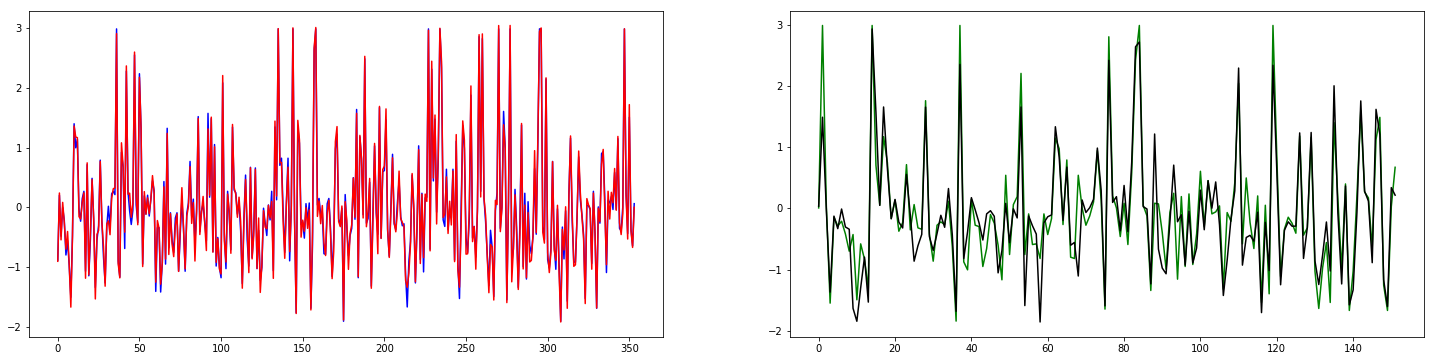

In [11]:
fig =plt.figure(figsize = (25,6))

ax1 = fig.add_subplot(121)
plt.plot(np.arange(y.numpy().shape[0]),y.numpy(),label = "True",color='b')
plt.plot(np.arange(out.data.numpy().shape[0]),out.data.numpy(),label = "Predict",alpha = 1,color='r')

ax2 = fig.add_subplot(122)
plt.plot(np.arange(test_output.numpy().shape[0]),test_output.numpy(),label = "True",color='g')
plt.plot(np.arange(y_hat.shape[0]),y_hat,label = "Predict",alpha = 1,color='k')

##### 保存模型，以及重新载入模型

In [12]:
# 保存模型
torch.save(fourlayer_network_Boston,'boston.pth')
# 导入模型
boston_model = torch.load('save_seq_net.pth')

D:\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


* 保存模型的后缀一般为 ".pth",代表pytorch的意思

#### 使用nn.Module来构建模型

In [13]:
class boston_model(nn.Module):
    def __init__(self,num_input,num_hidden1,num_hidden2,num_hidden3,num_hidden4,num_output):
        super(boston_model,self).__init__()      
        self.layer1 = nn.Linear(num_input, num_hidden1)     # 在init()函数中定义好需要的积木,在forward()函数中，进行组装
        self.layer2 = nn.Tanh()
        self.layer3 = nn.Linear(num_hidden1,num_hidden2)     # layer1, layer2, layer3 都是自己取的名字，可以更换
        self.layer4 = nn.Tanh()
        self.layer5 = nn.Linear(num_hidden2,num_hidden3)
        self.layer6 = nn.Tanh()
        self.layer7 = nn.Linear(num_hidden3,num_hidden4)
        self.layer8 = nn.Tanh()
        self.layer9 = nn.Linear(num_hidden4,num_output)
        
    def forward(self, x):         # forward() 函数是实例化 class boston_model() 类的时候，必须要执行的函数，因此函数名不能改变
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        return x

In [14]:
# 构建模型,优化器和损失函数
fourlayers_boston_model = boston_model(13,20,10,10,10,1)
optim = torch.optim.SGD(fourlayers_boston_model.parameters(), 1e-1)
criterion = nn.MSELoss() 

In [15]:
#训练模型
for epoch in range(10000):
    out = fourlayers_boston_model(Variable(x))   # 训练模型/求损失函数都能直接使用Variable计算
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (epoch + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(epoch+1, loss.item()))

epoch: 1000, loss: 0.053047988563776016
epoch: 2000, loss: 0.034697845578193665
epoch: 3000, loss: 0.02780870907008648
epoch: 4000, loss: 0.021735865622758865
epoch: 5000, loss: 0.01835721917450428
epoch: 6000, loss: 0.0169372595846653
epoch: 7000, loss: 0.015192295424640179
epoch: 8000, loss: 0.01379681471735239
epoch: 9000, loss: 0.012018873356282711
epoch: 10000, loss: 0.011597548611462116


In [16]:
# 保存模型
torch.save(fourlayers_boston_model,'bostons.pth')

D:\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type boston_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
